In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2023, 2024)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2023.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,401525434,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0
1,401540199,2023,1,regular,True,True,3689.0,2382,Mercer,Southern,fcs,17.0,NaN,2453,North Alabama,UAC,fcs,7.0,NaN
2,401520145,2023,1,regular,True,False,3662.0,55,Jacksonville State,Conference USA,fbs,17.0,1500.0,2638,UTEP,Conference USA,fbs,14.0,1369.0
3,401525450,2023,1,regular,True,False,3601.0,166,New Mexico State,Conference USA,fbs,30.0,1322.0,113,Massachusetts,FBS Independents,fbs,41.0,1074.0
4,401540628,2023,1,regular,True,False,4419.0,399,UAlbany,CAA,fcs,34.0,NaN,2230,Fordham,Patriot,fcs,13.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del df_season_plays, season_dfs, df_tmp

    all_dfs.append(df_season_plays)
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2023.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,401540244104995401,40154024433,401540244,22,6,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,67,67,3,28,5,False,Rush,Carlos Matheney run for 5 yds to the LAM 39,0.003424,0,45
1,401540244104994901,40154024433,401540244,22,5,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,66,66,2,27,-1,False,Rush,Carlos Matheney run for a loss of 1 yard to th...,-0.145843,0,50
2,401540244104977803,40154024433,401540244,22,4,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,64,64,1,25,-2,False,Rush,Carlos Matheney run for a loss of 2 yards to t...,-0.464241,2,21
3,401540244104977802,40154024433,401540244,22,3,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,49,49,1,10,-15,False,Rush,"Idaho Penalty, face mask (15 yards) (Carlos Ma...",-3.323128,2,21
4,401540244104977801,40154024433,401540244,22,2,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,65,65,3,10,16,False,Rush,Jack Layne run for 16 yds to the LAM 49 for a ...,3.095490,2,21


In [6]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos.head()

,season,week,team_id,team,division,elo
0,2023,1,2,Auburn,fbs,2461.917368
1,2023,1,2,Auburn,fbs,2461.917368
2,2023,2,2,Auburn,fbs,2386.104340
3,2023,3,2,Auburn,fbs,2414.568283
4,2023,4,2,Auburn,fbs,2430.356172


## 2. Join and Filter the Data

In [7]:
# Merge games and plays data
cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id', 
        'home_team','home_id','home_points', 
        'away_team','away_id', 'away_points']

id_cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number','season', 'week']

elo_cols = ['season', 'week', 'division', 'team_id', 'elo']

df = (
    df_games[cols].merge(df_plays, left_on='id', right_on='game_id', suffixes=('_game', ''))
    .drop(columns=['id_game'])
    .rename(columns={'id': 'play_id'})
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'division': 'home_division', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'division': 'away_division', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
)
df = df[id_cols + [c for c in df.columns if c not in id_cols]]
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo
0,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,Notre Dame,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30,fbs,3136.803907,fbs,1873.803009
1,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,Notre Dame,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30,fbs,3136.803907,fbs,1873.803009
2,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,Notre Dame,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30,fbs,3136.803907,fbs,1873.803009
3,401525434,40152543416,401525434104989901,16,7,2023,1,regular,True,True,3504.0,Notre Dame,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,38,62,1,10,2,False,Pass Reception,Steve Angeli pass complete to Rico Flores for ...,-0.665638,1,0,fbs,3136.803907,fbs,1873.803009
4,401525434,40152543416,401525434104989901,16,7,2023,1,regular,True,True,3504.0,Notre Dame,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,38,62,1,10,2,False,Pass Reception,Steve Angeli pass complete to Rico Flores for ...,-0.665638,1,0,fbs,3136.803907,fbs,1873.803009


In [8]:
# Filter out overtime plays
df = df.query('period <= 4')

# Game must be completed
df = df.query('completed == True')

In [9]:
df.isna().sum()

game_id                   0
drive_id                  0
play_id                   0
drive_number              0
play_number               0
season                    0
week                      0
season_type               0
completed                 0
neutral_site              0
venue_id                  0
home_team                 0
home_id                   0
home_points               0
away_team                 0
away_id                   0
away_points               0
offense                   0
offense_conference     1062
offense_score             0
defense                   0
home                      0
away                      0
defense_conference     1232
defense_score             0
period                    0
offense_timeouts          0
defense_timeouts          0
yardline                  0
yards_to_goal             0
down                      0
distance                  0
yards_gained              0
scoring                   0
play_type                 0
play_text           

## 3. Feature Engineering

In [10]:
df = df.assign(
    pct_game_played = (((df['period'] - 1) * 15 * 60) + ((15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))) / (4 * 15 * 60),
    score_diff = df['offense_score'] - df['defense_score'],
    home_team = np.select([df.neutral_site, df.offense == df.home], [0, 1], default=-1),
    pregame_elo_diff = np.where(df['offense'] == df['home'], df['home_pregame_elo'] - df['away_pregame_elo'], df['away_pregame_elo'] - df['home_pregame_elo']),
    pregame_offense_elo = np.where(df['offense'] == df['home'], df['home_pregame_elo'], df['away_pregame_elo']),
    pregame_defense_elo = np.where(df['offense'] == df['home'], df['away_pregame_elo'], df['home_pregame_elo']),
    offense_division = np.where(df['offense'] == df['home'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home'], df['away_division'], df['home_division']),
    score_diff_final = np.where(df['offense'] == df['home'], df['home_points'] - df['away_points'], df['away_points'] - df['home_points'])
)

df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,pct_game_played,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,score_diff_final
0,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,0,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30,fbs,3136.803907,fbs,1873.803009,0.991667,39,1263.000898,3136.803907,1873.803009,fbs,fbs,39.0
1,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,0,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30,fbs,3136.803907,fbs,1873.803009,0.991667,39,1263.000898,3136.803907,1873.803009,fbs,fbs,39.0
2,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,0,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30,fbs,3136.803907,fbs,1873.803009,0.991667,39,1263.000898,3136.803907,1873.803009,fbs,fbs,39.0
3,401525434,40152543416,401525434104989901,16,7,2023,1,regular,True,True,3504.0,0,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,38,62,1,10,2,False,Pass Reception,Steve Angeli pass complete to Rico Flores for ...,-0.665638,1,0,fbs,3136.803907,fbs,1873.803009,0.983333,39,1263.000898,3136.803907,1873.803009,fbs,fbs,39.0
4,401525434,40152543416,401525434104989901,16,7,2023,1,regular,True,True,3504.0,0,87,42.0,Navy,2426,3.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,38,62,1,10,2,False,Pass Reception,Steve Angeli pass complete to Rico Flores for ...,-0.665638,1,0,fbs,3136.803907,fbs,1873.803009,0.983333,39,1263.000898,3136.803907,1873.803009,fbs,fbs,39.0


In [11]:
df.columns

Index(['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number',
       'season', 'week', 'season_type', 'completed', 'neutral_site',
       'venue_id', 'home_team', 'home_id', 'home_points', 'away_team',
       'away_id', 'away_points', 'offense', 'offense_conference',
       'offense_score', 'defense', 'home', 'away', 'defense_conference',
       'defense_score', 'period', 'offense_timeouts', 'defense_timeouts',
       'yardline', 'yards_to_goal', 'down', 'distance', 'yards_gained',
       'scoring', 'play_type', 'play_text', 'ppa', 'clock_minutes',
       'clock_seconds', 'home_division', 'home_pregame_elo', 'away_division',
       'away_pregame_elo', 'pct_game_played', 'score_diff', 'pregame_elo_diff',
       'pregame_offense_elo', 'pregame_defense_elo', 'offense_division',
       'defense_division', 'score_diff_final'],
      dtype='object')

## 4. Final Data

In [12]:
cols = ['game_id', 'drive_id', 'play_id', 'season', 'week', 'season_type', 'venue_id', 
        'offense', 'offense_conference', 'offense_division', 
        'defense', 'defense_conference', 'defense_division', 
        'score_diff', 'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo', 'pct_game_played',
        'offense_timeouts', 'defense_timeouts', 'home_team', 'yards_to_goal',
        'score_diff_final']

#TODO: remove filtering for FBS only?
df = df[cols].query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,home_team,yards_to_goal,score_diff_final
0,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.991667,2.0,1.0,0,60,39.0
1,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.991667,2.0,1.0,0,60,39.0
2,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.991667,2.0,1.0,0,60,39.0
3,401525434,40152543416,401525434104989901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.983333,2.0,1.0,0,62,39.0
4,401525434,40152543416,401525434104989901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.983333,2.0,1.0,0,62,39.0


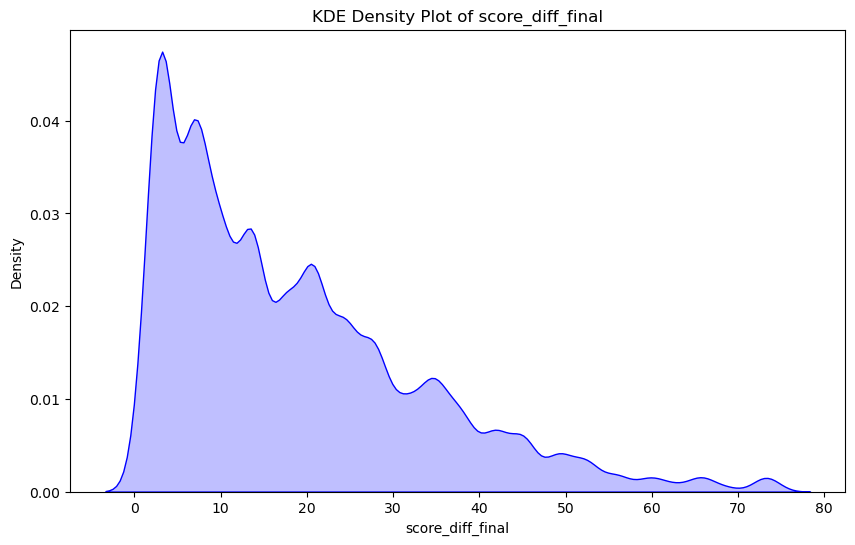

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.query('score_diff_final >= 0').score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

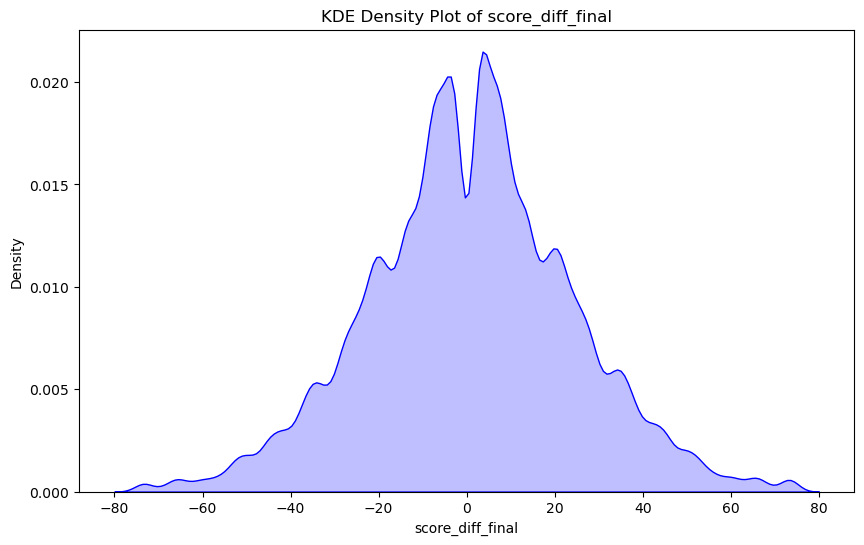

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

In [15]:
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,home_team,yards_to_goal,score_diff_final
0,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.991667,2.0,1.0,0,60,39.0
1,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.991667,2.0,1.0,0,60,39.0
2,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.991667,2.0,1.0,0,60,39.0
3,401525434,40152543416,401525434104989901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.983333,2.0,1.0,0,62,39.0
4,401525434,40152543416,401525434104989901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,1263.000898,3136.803907,1873.803009,0.983333,2.0,1.0,0,62,39.0


In [16]:
df['won'] = np.where(df['score_diff_final'] > 0, 1, 0)

## 5. Make the model

In [17]:
data = df[['game_id','score_diff','pregame_elo_diff','pct_game_played','home_team',
           'offense_timeouts','defense_timeouts','yards_to_goal']]
target = df[['won']]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
target_train = target[target.index.isin(data_train.index)]

data_test = data[data.game_id.isin(game_ids_test)].drop(columns='game_id')
target_test = target[target.index.isin(data_test.index)]

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    game_ids = data_train.game_id.unique()
    game_ids_train, game_ids_valid = train_test_split(game_ids, test_size=0.2, random_state=42)
  
    train_x = data_train[data_train.game_id.isin(game_ids_train)].drop(columns='game_id')
    valid_x = data_train[data_train.game_id.isin(game_ids_valid)].drop(columns='game_id')
    train_y = target_train[target_train.index.isin(train_x.index)].values.ravel()
    valid_y = target_train[target_train.index.isin(valid_x.index)].values.ravel()
  
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)
  
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]), # gblinear
        "lambda": trial.suggest_float("lambda", 1e-5, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 1.0, log=True),
        "eta": trial.suggest_float("eta", 0.01, 0.3, step=0.01),
    }
  
    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_float("min_child_weight", .5, 10, step=.5)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        param["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)
        param["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.5, 1.0)
  
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", .05, 1.0, step=.05)
        param["skip_drop"] = trial.suggest_float("skip_drop", .5, 1.0, step=.1)
    
    # if param["booster"] == "gblinear":
    #     param["feature_selector"] = trial.suggest_categorical("feature_selector", ["cyclic", "shuffle"])
    #     param["updater"] = trial.suggest_categorical("updater", ["shotgun", "coord_descent"])
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

storage = "sqlite:///studies/wp_hyperopt.db"
study = optuna.create_study(
    study_name="win_probability_hyperopt", 
    storage=storage, 
    direction="minimize", 
    load_if_exists=True
)
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best value:", study.best_value)

[I 2025-03-28 20:09:38,004] A new study created in RDB with name: win_probability_hyperopt
[I 2025-03-28 20:09:38,249] Trial 0 finished with value: 0.3847327878269939 and parameters: {'booster': 'gbtree', 'lambda': 0.04855093170449416, 'alpha': 7.540153786761627e-05, 'eta': 0.19, 'max_depth': 5, 'min_child_weight': 6.0, 'gamma': 0.04346261551005116, 'grow_policy': 'depthwise', 'subsample': 0.6113311359350824, 'colsample_bytree': 0.5321380949316721}. Best is trial 0 with value: 0.3847327878269939.
[I 2025-03-28 20:09:41,757] Trial 1 finished with value: 0.37526024040349937 and parameters: {'booster': 'dart', 'lambda': 0.006871490369381701, 'alpha': 0.0013600519010753536, 'eta': 0.060000000000000005, 'max_depth': 5, 'min_child_weight': 6.0, 'gamma': 1.3956686961420269e-06, 'grow_policy': 'lossguide', 'subsample': 0.7826462322029865, 'colsample_bytree': 0.8642277327289087, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3805990709808787e-06, 'skip_drop': 0.0013715151

Best parameters: {'booster': 'gbtree', 'lambda': 0.0003858812583853379, 'alpha': 1.2725609837758118e-05, 'eta': 0.02, 'max_depth': 3, 'min_child_weight': 3.5, 'gamma': 0.00022037619150756747, 'grow_policy': 'depthwise', 'subsample': 0.9523888617078548, 'colsample_bytree': 0.6073977874653028}
Best value: 0.3588529841467135


[0]	train-logloss:0.68677	eval-logloss:0.68665
[1]	train-logloss:0.68506	eval-logloss:0.68464
[2]	train-logloss:0.67568	eval-logloss:0.67567
[3]	train-logloss:0.66762	eval-logloss:0.66791
[4]	train-logloss:0.66208	eval-logloss:0.66189
[5]	train-logloss:0.65676	eval-logloss:0.65610
[6]	train-logloss:0.64923	eval-logloss:0.64886
[7]	train-logloss:0.64422	eval-logloss:0.64338
[8]	train-logloss:0.63696	eval-logloss:0.63646
[9]	train-logloss:0.63009	eval-logloss:0.62987
[10]	train-logloss:0.62565	eval-logloss:0.62532
[11]	train-logloss:0.61838	eval-logloss:0.61825
[12]	train-logloss:0.61424	eval-logloss:0.61401
[13]	train-logloss:0.61024	eval-logloss:0.60992
[14]	train-logloss:0.60906	eval-logloss:0.60853
[15]	train-logloss:0.60507	eval-logloss:0.60409
[16]	train-logloss:0.60478	eval-logloss:0.60377
[17]	train-logloss:0.60094	eval-logloss:0.59949
[18]	train-logloss:0.59438	eval-logloss:0.59310
[19]	train-logloss:0.59093	eval-logloss:0.58955
[20]	train-logloss:0.58475	eval-logloss:0.58349
[2

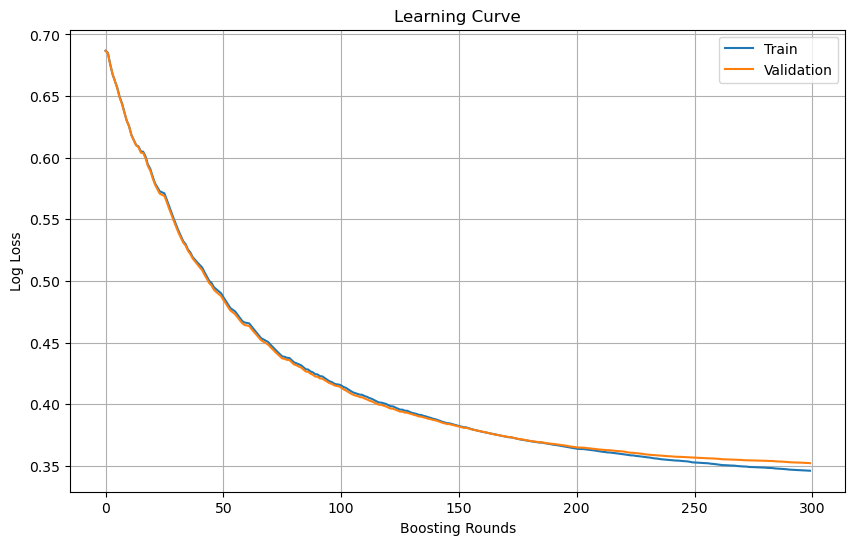

In [58]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Get the best parameters from the Optuna study
best_params = {'booster': 'gbtree', 'lambda': 0.0004, 'alpha': 0, 'eta': 0.02, 
               'max_depth': 3, 'min_child_weight': 3.5, 'gamma': 0.0002, 
               'grow_policy': 'depthwise', 'subsample': 0.95, 'colsample_bytree': 0.6}

# Add additional parameters required for training
best_params.update({
    "objective": "binary:logistic",
    "nthread": -1,
})

# Perform train-validation split
game_ids = data_train.game_id.unique()
game_ids_train, game_ids_valid = train_test_split(game_ids, test_size=0.2, random_state=123)

train_x = data_train[data_train.game_id.isin(game_ids_train)].drop(columns='game_id')
valid_x = data_train[data_train.game_id.isin(game_ids_valid)].drop(columns='game_id')
train_y = target_train[target_train.index.isin(train_x.index)].values.ravel()
valid_y = target_train[target_train.index.isin(valid_x.index)].values.ravel()

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Train the model with early stopping
evals_result = {}
model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, "train"), (dvalid, "eval")],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

preds = model.predict(dtrain)
logloss = log_loss(train_y, preds)
print(f"Training Log Loss: {logloss}")
preds = model.predict(dvalid)
logloss = log_loss(valid_y, preds)
print(f"Validation Log Loss: {logloss}")

# Plot the learning curve
def plot_learning_curve(evals_result):
    train_metric = evals_result["train"]["logloss"]
    eval_metric = evals_result["eval"]["logloss"]

    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label="Train")
    plt.plot(eval_metric, label="Validation")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("Log Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(evals_result)

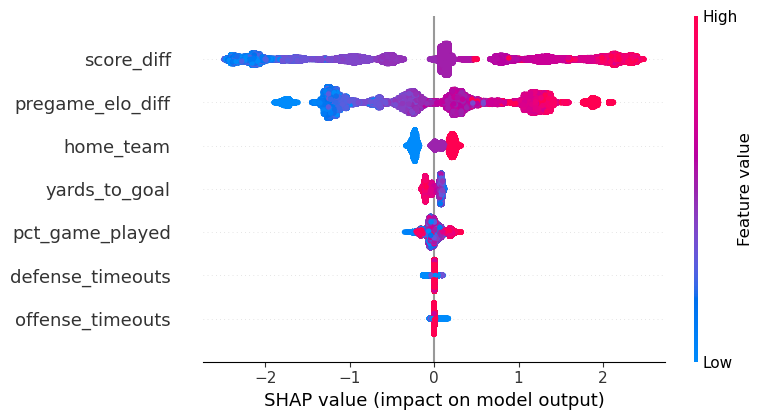

In [59]:
# SHAP values for feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)

# Plot SHAP summary
shap.summary_plot(shap_values, train_x)

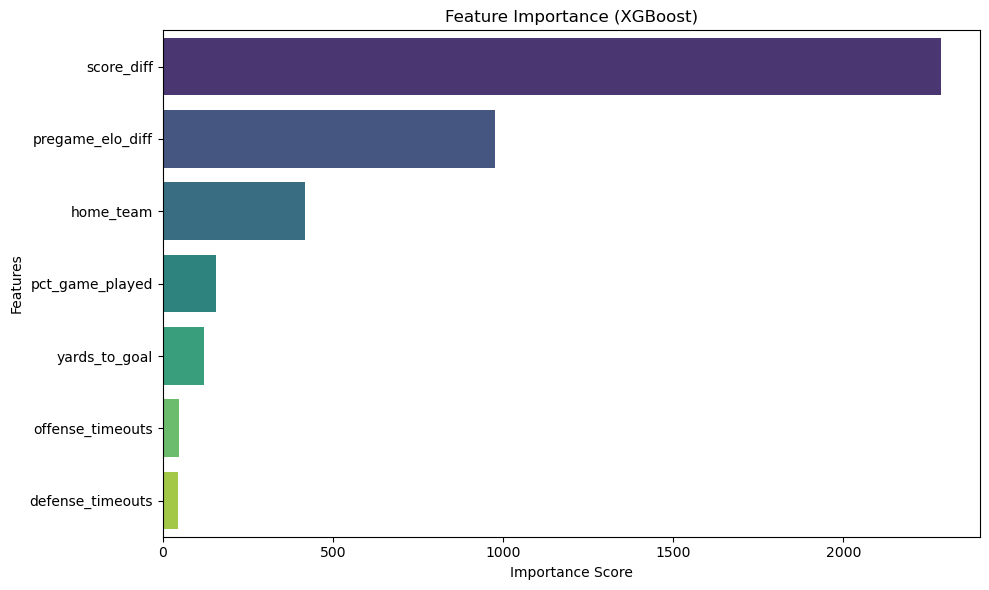

In [60]:
def plot_feature_importance(model):
    # Get feature importance scores
    importance = model.get_score(importance_type="gain")  # weight, gain, cover
    
    # Convert to a DataFrame for easier plotting
    importance_df = pd.DataFrame({
        "Feature": list(importance.keys()),
        "Importance": list(importance.values())
    }).sort_values(by="Importance", ascending=False)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis",  # Custom color palette
        hue="Feature",      # Assign `Feature` to `hue`
        dodge=False         # Avoid splitting bars
    )
    plt.title("Feature Importance (XGBoost)")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)  # Remove the legend
    plt.tight_layout()
    plt.show()

# Call the function
plot_feature_importance(model)

In [62]:
dtest = xgb.DMatrix(data_test)
preds = model.predict(dtest)
logloss = log_loss(target_test.values.ravel(), preds)
print(f"Test Log Loss: {logloss}")

Test Log Loss: 0.4040231964516485


In [64]:
#make predictions on complete dataset
data_all = data.drop(columns='game_id')
dall = xgb.DMatrix(data_all)
preds_all = model.predict(dall)
df['wp'] = preds_all

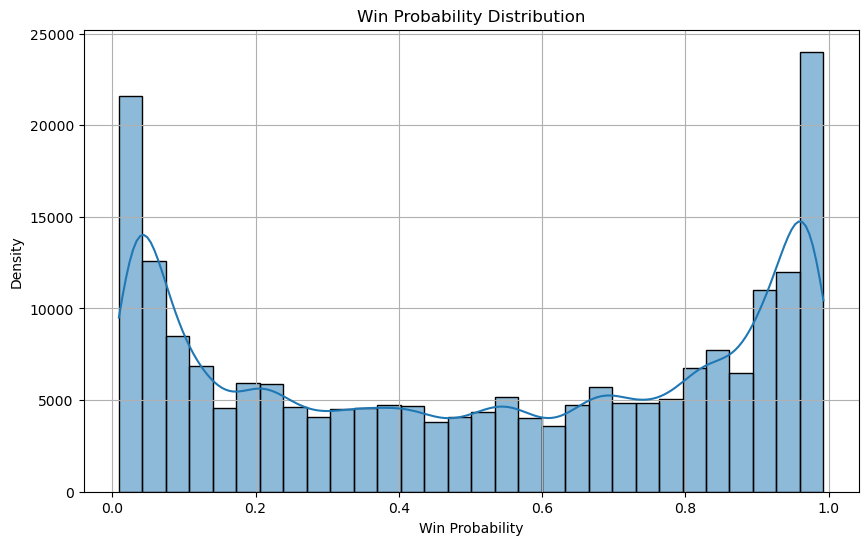

In [66]:
# plot win probability
def plot_wp(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['wp'], bins=30, kde=True)
    plt.title('Win Probability Distribution')
    plt.xlabel('Win Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df)

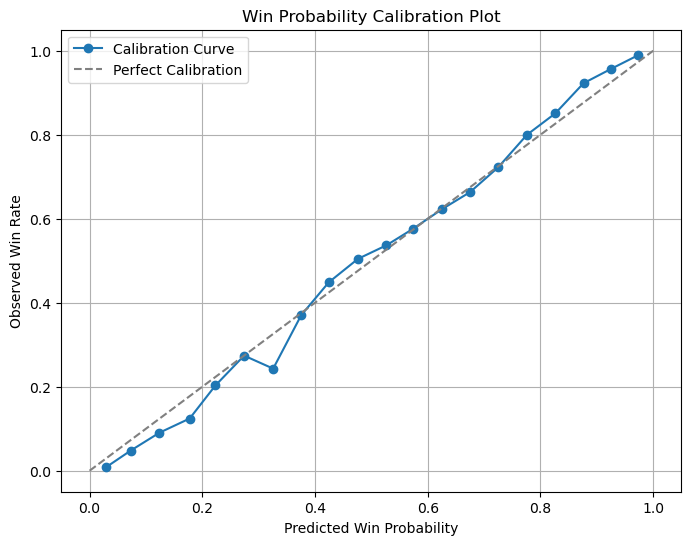

In [67]:
def plot_calibration(df, wp_col, actual_col, bins=100):
    df['wp_bin'] = pd.cut(df[wp_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('wp_bin').agg(
        predicted_wp=('wp', 'mean'),
        actual_wp=(actual_col, 'mean'),
        count=('wp', 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_wp'], calibration['actual_wp'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Win Probability')
    plt.ylabel('Observed Win Rate')
    plt.title('Win Probability Calibration Plot')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
df['actual_win'] = (df['score_diff_final'] > 0).astype(int)  # 1 if the team won, 0 otherwise
plot_calibration(df, wp_col='wp', actual_col='actual_win', bins=20)

In [68]:
df.preds.describe()

count    211246.000000
mean          0.516250
std           0.347581
min           0.009103
25%           0.162091
50%           0.535797
75%           0.864990
max           0.992554
Name: preds, dtype: float64

In [90]:
df.game_id.value_counts()

game_id
401551789    1557
401523986    1539
401551751    1242
401551788    1128
401532392    1086
401523997    1080
401531838    1056
401520145    1020
401551746     990
401551732     990
401532573     978
401525450     978
401551733     960
401551786     942
401520181     924
401581109     918
401551798     840
401551778     828
401551769     828
401551765     772
401551737     764
401551735     760
401532394     760
401551753     760
401520157     752
401520168     744
401525468     744
401551749     720
401520172     720
401551743     720
401551757     720
401520160     716
401551754     716
401525825     712
401551750     708
401525464     708
401551768     708
401551755     700
401525822     700
401525467     700
401520171     700
401523995     700
401525462     696
401551748     696
401551766     696
401551764     692
401551744     688
401551469     688
401520146     684
401551770     680
401551739     680
401520169     676
401551780     672
401551741     672
401551752     668
40

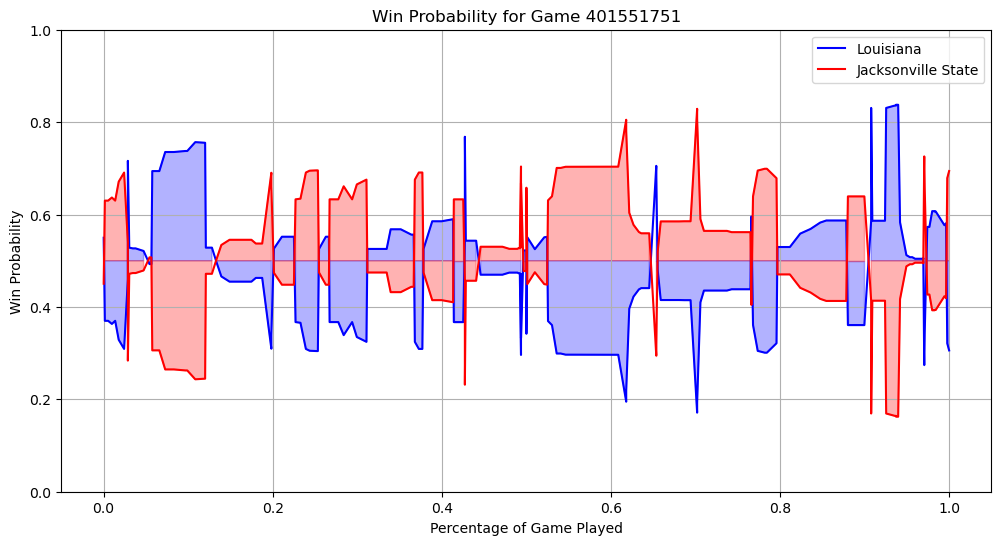

In [84]:
def plot_wp_game(df, game_id):
    cols = ['game_id', 'drive_id', 'play_id', 'pct_game_played', 'offense', 'wp', 'score_diff']
    game = (
        df.query('game_id == @game_id')
        .sort_values(['pct_game_played','play_id'], ascending=[True, True])
        [cols]
    )
    teams = game.offense.unique()
    t1, t2 = game.copy(), game.copy()
    t1['wp'] = np.where(t1['offense'] == teams[0], t1['wp'], 1 - t1['wp'])
    t2['wp'] = np.where(t2['offense'] == teams[1], t2['wp'], 1 - t2['wp'])

    plt.figure(figsize=(12, 6))
    plt.plot(t1['pct_game_played'], t1['wp'], label=teams[0], color='blue')
    plt.fill_between(t1['pct_game_played'], t1['wp'], 0.5, where=(t1['wp'] >= 0.5), color='blue', alpha=0.3)
    plt.fill_between(t1['pct_game_played'], t1['wp'], 0.5, where=(t1['wp'] < 0.5), color='blue', alpha=0.3)

    plt.plot(t2['pct_game_played'], t2['wp'], label=teams[1], color='red')
    plt.fill_between(t2['pct_game_played'], t2['wp'], 0.5, where=(t2['wp'] >= 0.5), color='red', alpha=0.3)
    plt.fill_between(t2['pct_game_played'], t2['wp'], 0.5, where=(t2['wp'] < 0.5), color='red', alpha=0.3)

    plt.title(f'Win Probability for Game {game_id}')
    plt.xlabel('Percentage of Game Played')
    plt.ylabel('Win Probability')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()

plot_wp_game(df, 401551751)